# VAE Model Visualization and Analysis

This notebook loads a trained VAE model and visualizes original structures alongside their reconstructions, including RMSD analysis.


In [76]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pathlib import Path
import sys
import os

# Add the parent directory to the path to import our modules
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

from VAE.Simple_VAE import LGL_VAE
from Utils.Utils import Utils
from DataLoader.Chromosome21PDBDataset import Chromosome21PDBDataset
from torch.utils.data import DataLoader

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


## Configuration and Model Loading


In [87]:
# Configuration
PDB_PATH = "../../Data/chromosome21_aligned.pdb"
MODEL_PATH = "../../outputs/Large_Latent_Dim/trained_vae_model_RMSD_64_Latent_Dim.pt"
NUM_SAMPLES = 15  # Number of structures to visualize

# Model hyperparameters (should match training)
HIDDEN_DIM = 4096
LATENT_DIM = 64

# Initialize Utils
utils = Utils()
print(f"Using device: {utils.device}")


Using device: cpu


In [88]:
# Load dataset
print("Loading dataset...")
dataset = Chromosome21PDBDataset(
    pdb_path=PDB_PATH,
    record_types=("ATOM",),
    center=True,
    scale=1.0
)

print(f"Dataset loaded: {len(dataset)} models, {dataset.vector_length} coordinates per model")
print(f"Number of atoms per model: {dataset.atoms_per_model}")

# Create model
vae = LGL_VAE(hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, input_dim=dataset.vector_length)
vae = vae.to(utils.device)

# Load trained model
if Path(MODEL_PATH).exists():
    # Load the state dict
    state_dict = torch.load(MODEL_PATH, map_location=utils.device)
    
    # Check if the model was saved with DataParallel (has "module." prefix)
    if any(key.startswith("module.") for key in state_dict.keys()):
        print("Model was saved with DataParallel, removing 'module.' prefix...")
        # Remove the "module." prefix from all keys
        new_state_dict = {}
        for key, value in state_dict.items():
            new_key = key.replace("module.", "")
            new_state_dict[new_key] = value
        state_dict = new_state_dict
    
    # Load the state dict into the model
    vae.load_state_dict(state_dict)
    print(f"Loaded trained model from {MODEL_PATH}")
    vae.eval()
else:
    print(f"Model file not found at {MODEL_PATH}")
    print("Please train the model first using main_RMSD.py")


Loading dataset...
Dataset loaded: 7591 models, 1953 coordinates per model
Number of atoms per model: 651
Model was saved with DataParallel, removing 'module.' prefix...
Loaded trained model from ../../outputs/Large_Latent_Dim/trained_vae_model_RMSD_64_Latent_Dim.pt


## RMSD Calculation Function


In [89]:
def compute_rmsd(coords1, coords2):
    """
    Compute RMSD between two sets of coordinates.
    
    Args:
        coords1: [N, 3] tensor of coordinates
        coords2: [N, 3] tensor of coordinates
    
    Returns:
        rmsd: scalar RMSD value
    """
    # Ensure both coordinate sets have the same number of atoms
    min_atoms = min(coords1.shape[0], coords2.shape[0])
    coords1 = coords1[:min_atoms]
    coords2 = coords2[:min_atoms]
    
    # Compute RMSD
    squared_diff = torch.sum((coords1 - coords2) ** 2, dim=1)
    mean_squared_diff = torch.mean(squared_diff)
    rmsd = torch.sqrt(mean_squared_diff)
    
    return rmsd.item()

def compute_pairwise_distances(coords):
    """
    Compute pairwise distances for a single structure.
    
    Args:
        coords: [N, 3] tensor of coordinates
    
    Returns:
        distances: [N*(N-1)//2] tensor of pairwise distances
    """
    return torch.pdist(coords, p=2)

def compute_radius_of_gyration(coords):
    """
    Compute radius of gyration for a single structure.
    
    Args:
        coords: [N, 3] tensor of coordinates
    
    Returns:
        rog: scalar radius of gyration
    """
    center_of_mass = torch.mean(coords, dim=0, keepdim=True)
    coords_centered = coords - center_of_mass
    squared_distances = torch.sum(coords_centered ** 2, dim=1)
    rog = torch.sqrt(torch.mean(squared_distances))
    return rog.item()

def compute_angles(coords):
    """
    Compute angles between consecutive triplets of beads.
    
    Args:
        coords: [N, 3] tensor of coordinates
    
    Returns:
        angles: [N-2] tensor of angles in radians
    """
    if coords.shape[0] < 3:
        return torch.tensor([])
    
    # Get vectors for angle computation
    v1 = coords[:-2] - coords[1:-1]  # [N-2, 3]
    v2 = coords[2:] - coords[1:-1]   # [N-2, 3]
    
    # Compute dot product
    dot_product = torch.sum(v1 * v2, dim=1)  # [N-2]
    
    # Compute magnitudes
    v1_magnitude = torch.norm(v1, dim=1)  # [N-2]
    v2_magnitude = torch.norm(v2, dim=1)  # [N-2]
    
    # Avoid division by zero
    magnitude_product = v1_magnitude * v2_magnitude
    magnitude_product = torch.clamp(magnitude_product, min=1e-8)
    
    # Compute cosine of angle
    cos_angle = dot_product / magnitude_product
    cos_angle = torch.clamp(cos_angle, min=-1.0 + 1e-6, max=1.0 - 1e-6)
    
    # Compute angles in radians
    angles = torch.acos(cos_angle)  # [N-2]
    
    return angles


## Generate Reconstructions and Compute Metrics


In [90]:
# Select random samples for visualization
torch.manual_seed(42)  # For reproducibility
sample_indices = torch.randperm(len(dataset))[:NUM_SAMPLES]

original_structures = []
reconstructed_structures = []
rmsd_values = []
distance_correlations = []
rog_original = []
rog_reconstructed = []
angle_correlations = []

print(f"Processing {NUM_SAMPLES} structures...")

with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        # Get original structure
        original_flat = dataset[idx]  # [3*N_atoms]
        original_coords = original_flat.view(-1, 3)  # [N_atoms, 3]
        
        # Generate reconstruction
        original_flat_batch = original_flat.unsqueeze(0).to(utils.device)  # [1, 3*N_atoms]
        reconstructed_flat, mu, logvar = vae(original_flat_batch)
        reconstructed_coords = reconstructed_flat.squeeze(0).view(-1, 3).cpu()  # [N_atoms, 3]
        
        # Compute RMSD
        rmsd = compute_rmsd(original_coords, reconstructed_coords)
        
        # Compute pairwise distances
        orig_distances = compute_pairwise_distances(original_coords)
        recon_distances = compute_pairwise_distances(reconstructed_coords)
        distance_corr = torch.corrcoef(torch.stack([orig_distances, recon_distances]))[0, 1].item()
        
        # Compute radius of gyration
        orig_rog = compute_radius_of_gyration(original_coords)
        recon_rog = compute_radius_of_gyration(reconstructed_coords)
        
        # Compute angles
        orig_angles = compute_angles(original_coords)
        recon_angles = compute_angles(reconstructed_coords)
        if len(orig_angles) > 0 and len(recon_angles) > 0:
            angle_corr = torch.corrcoef(torch.stack([orig_angles, recon_angles]))[0, 1].item()
        else:
            angle_corr = 0.0
        
        # Store results
        original_structures.append(original_coords)
        reconstructed_structures.append(reconstructed_coords)
        rmsd_values.append(rmsd)
        distance_correlations.append(distance_corr)
        rog_original.append(orig_rog)
        rog_reconstructed.append(recon_rog)
        angle_correlations.append(angle_corr)
        
        print(f"Structure {i+1}: RMSD = {rmsd:.3f}, Distance Corr = {distance_corr:.3f}, Angle Corr = {angle_corr:.3f}")
        print(f"  Original RoG = {orig_rog:.3f}, Reconstructed RoG = {recon_rog:.3f}")

print(f"\nAverage RMSD: {np.mean(rmsd_values):.3f} ± {np.std(rmsd_values):.3f}")
print(f"Average Distance Correlation: {np.mean(distance_correlations):.3f} ± {np.std(distance_correlations):.3f}")
print(f"Average Angle Correlation: {np.mean(angle_correlations):.3f} ± {np.std(angle_correlations):.3f}")


Processing 15 structures...
Structure 1: RMSD = 3.348, Distance Corr = 0.805, Angle Corr = 0.257
  Original RoG = 7.391, Reconstructed RoG = 6.402
Structure 2: RMSD = 3.990, Distance Corr = 0.753, Angle Corr = 0.264
  Original RoG = 7.776, Reconstructed RoG = 6.265
Structure 3: RMSD = 5.114, Distance Corr = 0.818, Angle Corr = 0.303
  Original RoG = 11.973, Reconstructed RoG = 10.608
Structure 4: RMSD = 4.490, Distance Corr = 0.497, Angle Corr = 0.252
  Original RoG = 6.393, Reconstructed RoG = 4.204
Structure 5: RMSD = 4.317, Distance Corr = 0.862, Angle Corr = 0.262
  Original RoG = 11.322, Reconstructed RoG = 10.156
Structure 6: RMSD = 5.400, Distance Corr = 0.579, Angle Corr = 0.014
  Original RoG = 8.011, Reconstructed RoG = 6.302
Structure 7: RMSD = 4.176, Distance Corr = 0.704, Angle Corr = 0.214
  Original RoG = 7.458, Reconstructed RoG = 5.753
Structure 8: RMSD = 3.913, Distance Corr = 0.797, Angle Corr = 0.265
  Original RoG = 8.797, Reconstructed RoG = 7.675
Structure 9: RMS

## 3D Structure Visualization


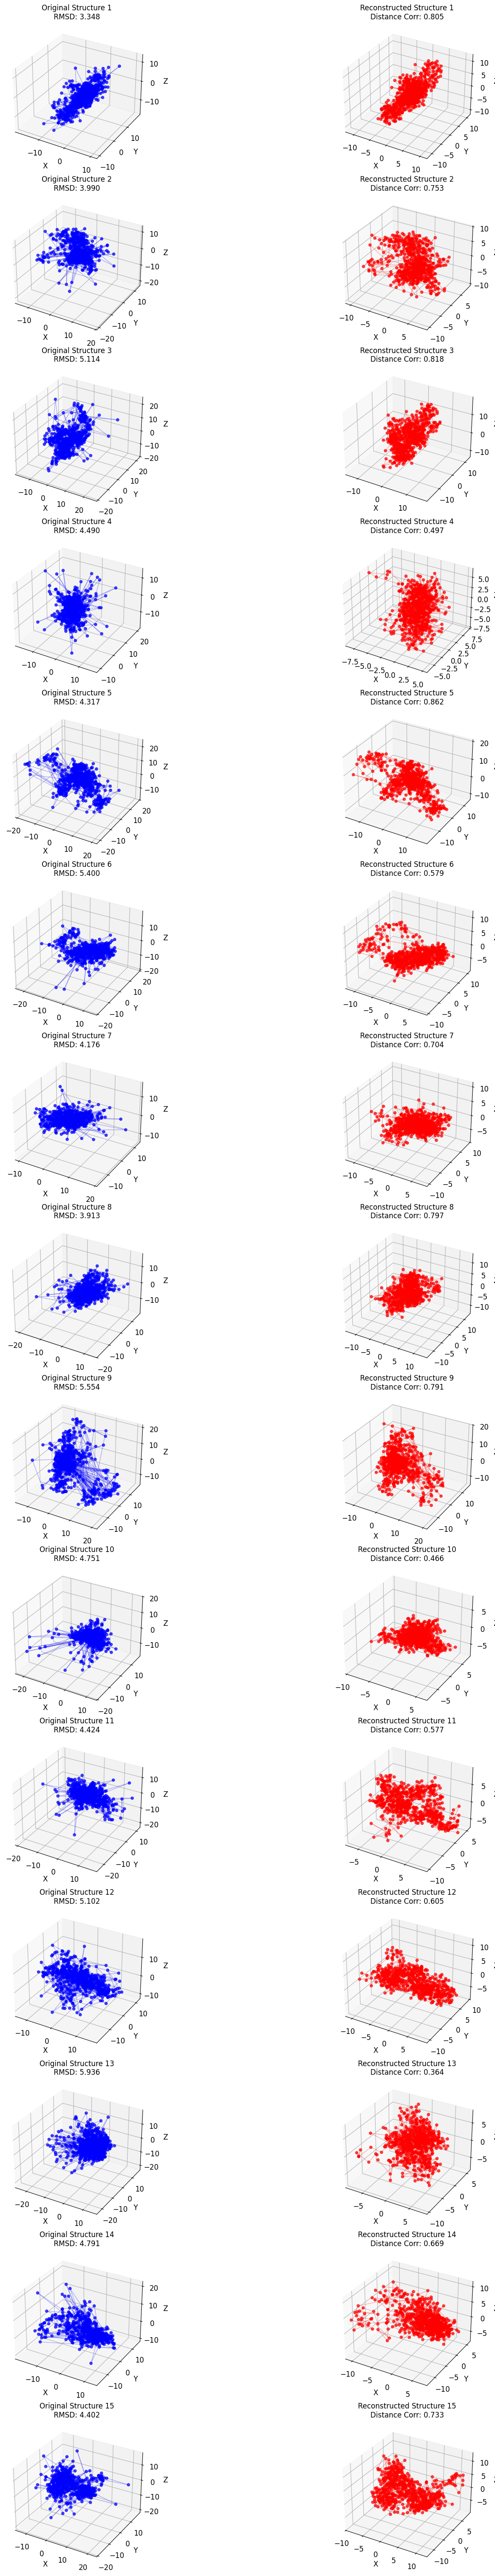

In [91]:
def plot_3d_structure(coords, title, ax, color='blue', alpha=0.6):
    """
    Plot a 3D structure.
    
    Args:
        coords: [N, 3] tensor of coordinates
        title: title for the plot
        ax: matplotlib 3D axis
        color: color for the points
        alpha: transparency
    """
    coords_np = coords.numpy()
    
    # Plot points
    ax.scatter(coords_np[:, 0], coords_np[:, 1], coords_np[:, 2], 
               c=color, s=20, alpha=alpha)
    
    # Plot connections between consecutive beads
    for i in range(len(coords_np) - 1):
        ax.plot([coords_np[i, 0], coords_np[i+1, 0]], 
                [coords_np[i, 1], coords_np[i+1, 1]], 
                [coords_np[i, 2], coords_np[i+1, 2]], 
                color=color, alpha=0.3, linewidth=1)
    
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Set equal aspect ratio
    max_range = np.array([coords_np[:, 0].max() - coords_np[:, 0].min(),
                         coords_np[:, 1].max() - coords_np[:, 1].min(),
                         coords_np[:, 2].max() - coords_np[:, 2].min()]).max() / 2.0
    mid_x = (coords_np[:, 0].max() + coords_np[:, 0].min()) * 0.5
    mid_y = (coords_np[:, 1].max() + coords_np[:, 1].min()) * 0.5
    mid_z = (coords_np[:, 2].max() + coords_np[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Create side-by-side plots for each structure
fig = plt.figure(figsize=(20, 4 * NUM_SAMPLES))

for i in range(NUM_SAMPLES):
    # Original structure
    ax1 = fig.add_subplot(NUM_SAMPLES, 2, 2*i + 1, projection='3d')
    plot_3d_structure(original_structures[i], 
                     f'Original Structure {i+1}\nRMSD: {rmsd_values[i]:.3f}', 
                     ax1, color='blue', alpha=0.7)
    
    # Reconstructed structure
    ax2 = fig.add_subplot(NUM_SAMPLES, 2, 2*i + 2, projection='3d')
    plot_3d_structure(reconstructed_structures[i], 
                     f'Reconstructed Structure {i+1}\nDistance Corr: {distance_correlations[i]:.3f}', 
                     ax2, color='red', alpha=0.7)

plt.tight_layout()
plt.show()


## Overlay Visualization (Original vs Reconstructed)


/tmp/ipykernel_1539891/468330617.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


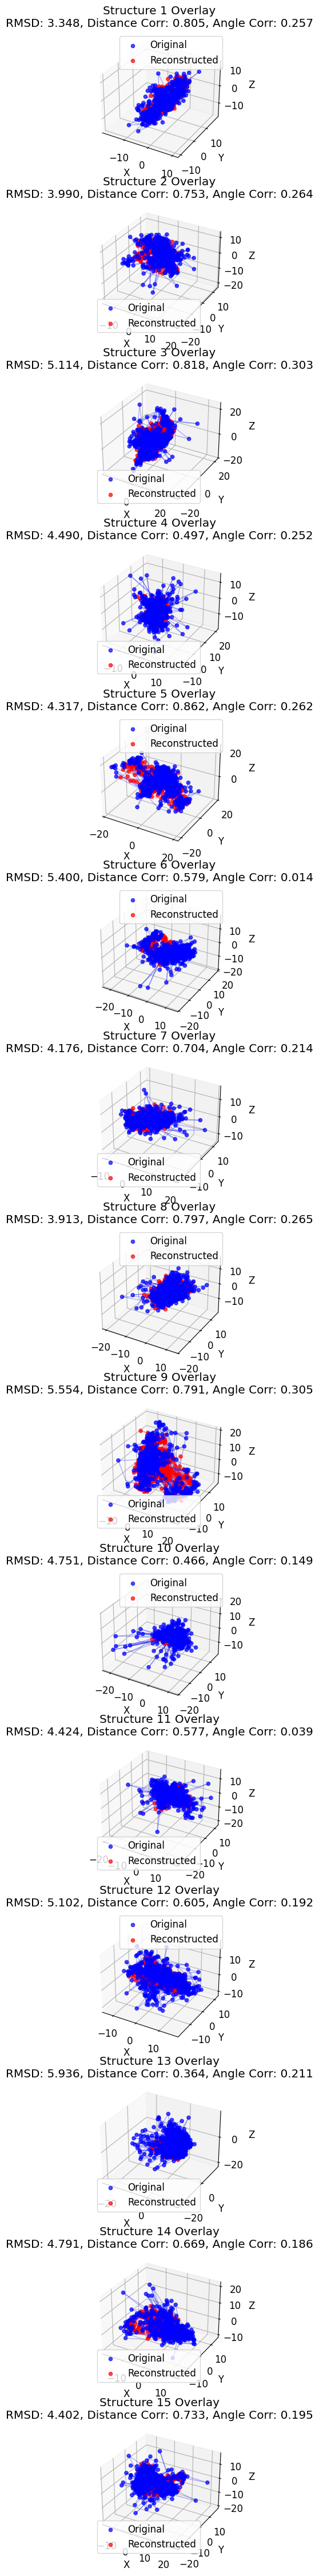

In [92]:
# Create overlay plots showing both structures together
fig = plt.figure(figsize=(15, 3 * NUM_SAMPLES))

for i in range(NUM_SAMPLES):
    ax = fig.add_subplot(NUM_SAMPLES, 1, i+1, projection='3d')
    
    # Plot original structure
    orig_coords = original_structures[i].numpy()
    ax.scatter(orig_coords[:, 0], orig_coords[:, 1], orig_coords[:, 2], 
               c='blue', s=20, alpha=0.7, label='Original')
    
    # Plot reconstructed structure
    recon_coords = reconstructed_structures[i].numpy()
    ax.scatter(recon_coords[:, 0], recon_coords[:, 1], recon_coords[:, 2], 
               c='red', s=20, alpha=0.7, label='Reconstructed')
    
    # Plot connections for original
    for j in range(len(orig_coords) - 1):
        ax.plot([orig_coords[j, 0], orig_coords[j+1, 0]], 
                [orig_coords[j, 1], orig_coords[j+1, 1]], 
                [orig_coords[j, 2], orig_coords[j+1, 2]], 
                color='blue', alpha=0.3, linewidth=1)
    
    # Plot connections for reconstructed
    for j in range(len(recon_coords) - 1):
        ax.plot([recon_coords[j, 0], recon_coords[j+1, 0]], 
                [recon_coords[j, 1], recon_coords[j+1, 1]], 
                [recon_coords[j, 2], recon_coords[j+1, 2]], 
                color='red', alpha=0.3, linewidth=1)
    
    ax.set_title(f'Structure {i+1} Overlay\nRMSD: {rmsd_values[i]:.3f}, Distance Corr: {distance_correlations[i]:.3f}, Angle Corr: {angle_correlations[i]:.3f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    
    # Set equal aspect ratio
    all_coords = np.vstack([orig_coords, recon_coords])
    max_range = np.array([all_coords[:, 0].max() - all_coords[:, 0].min(),
                         all_coords[:, 1].max() - all_coords[:, 1].min(),
                         all_coords[:, 2].max() - all_coords[:, 2].min()]).max() / 2.0
    mid_x = (all_coords[:, 0].max() + all_coords[:, 0].min()) * 0.5
    mid_y = (all_coords[:, 1].max() + all_coords[:, 1].min()) * 0.5
    mid_z = (all_coords[:, 2].max() + all_coords[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.tight_layout()
plt.show()


## Analysis Plots


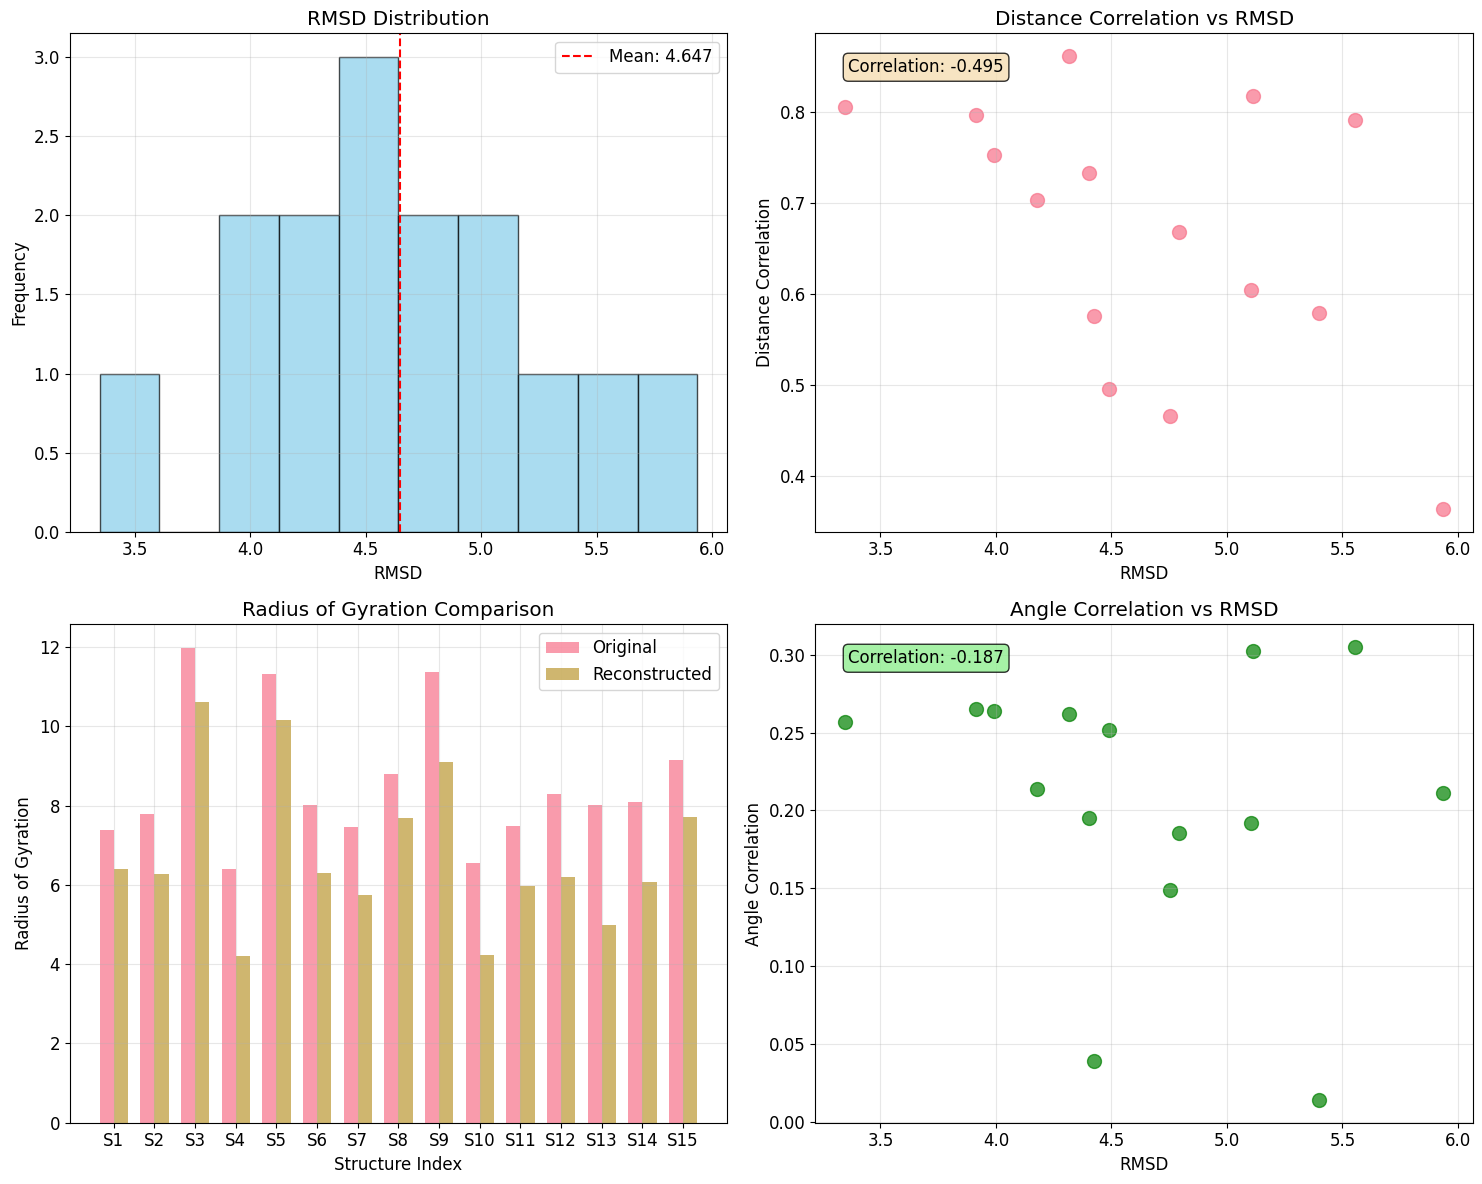

In [93]:
# Create analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# RMSD distribution
axes[0, 0].hist(rmsd_values, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(np.mean(rmsd_values), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(rmsd_values):.3f}')
axes[0, 0].set_xlabel('RMSD')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('RMSD Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Distance correlation vs RMSD
axes[0, 1].scatter(rmsd_values, distance_correlations, alpha=0.7, s=100)
axes[0, 1].set_xlabel('RMSD')
axes[0, 1].set_ylabel('Distance Correlation')
axes[0, 1].set_title('Distance Correlation vs RMSD')
axes[0, 1].grid(True, alpha=0.3)

# Add correlation coefficient
corr_coef = np.corrcoef(rmsd_values, distance_correlations)[0, 1]
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', 
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Radius of gyration comparison
x_pos = np.arange(len(rog_original))
width = 0.35
axes[1, 0].bar(x_pos - width/2, rog_original, width, label='Original', alpha=0.7)
axes[1, 0].bar(x_pos + width/2, rog_reconstructed, width, label='Reconstructed', alpha=0.7)
axes[1, 0].set_xlabel('Structure Index')
axes[1, 0].set_ylabel('Radius of Gyration')
axes[1, 0].set_title('Radius of Gyration Comparison')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([f'S{i+1}' for i in range(NUM_SAMPLES)])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Angle correlation vs RMSD
axes[1, 1].scatter(rmsd_values, angle_correlations, alpha=0.7, s=100, color='green')
axes[1, 1].set_xlabel('RMSD')
axes[1, 1].set_ylabel('Angle Correlation')
axes[1, 1].set_title('Angle Correlation vs RMSD')
axes[1, 1].grid(True, alpha=0.3)

# Add correlation coefficient
angle_corr_coef = np.corrcoef(rmsd_values, angle_correlations)[0, 1]
axes[1, 1].text(0.05, 0.95, f'Correlation: {angle_corr_coef:.3f}', 
                transform=axes[1, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()


## Summary Statistics


In [94]:
# Print detailed summary statistics
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"Number of structures analyzed: {NUM_SAMPLES}")
print(f"Number of atoms per structure: {dataset.atoms_per_model}")
print()

print("RMSD Analysis:")
print(f"  Mean RMSD: {np.mean(rmsd_values):.4f} ± {np.std(rmsd_values):.4f}")
print(f"  Min RMSD: {np.min(rmsd_values):.4f}")
print(f"  Max RMSD: {np.max(rmsd_values):.4f}")
print()

print("Distance Correlation Analysis:")
print(f"  Mean Distance Correlation: {np.mean(distance_correlations):.4f} ± {np.std(distance_correlations):.4f}")
print(f"  Min Distance Correlation: {np.min(distance_correlations):.4f}")
print(f"  Max Distance Correlation: {np.max(distance_correlations):.4f}")
print()

print("Angle Correlation Analysis:")
print(f"  Mean Angle Correlation: {np.mean(angle_correlations):.4f} ± {np.std(angle_correlations):.4f}")
print(f"  Min Angle Correlation: {np.min(angle_correlations):.4f}")
print(f"  Max Angle Correlation: {np.max(angle_correlations):.4f}")
print()

print("Radius of Gyration Analysis:")
print(f"  Original Mean RoG: {np.mean(rog_original):.4f} ± {np.std(rog_original):.4f}")
print(f"  Reconstructed Mean RoG: {np.mean(rog_reconstructed):.4f} ± {np.std(rog_reconstructed):.4f}")
print(f"  RoG Correlation: {np.corrcoef(rog_original, rog_reconstructed)[0, 1]:.4f}")
print()

print("Model Performance Assessment:")
if np.mean(distance_correlations) > 0.8:
    print("  ✓ Distance preservation: EXCELLENT")
elif np.mean(distance_correlations) > 0.6:
    print("  ✓ Distance preservation: GOOD")
else:
    print("  ⚠ Distance preservation: NEEDS IMPROVEMENT")

if np.mean(angle_correlations) > 0.7:
    print("  ✓ Angle preservation: EXCELLENT")
elif np.mean(angle_correlations) > 0.5:
    print("  ✓ Angle preservation: GOOD")
else:
    print("  ⚠ Angle preservation: NEEDS IMPROVEMENT")

if np.mean(rmsd_values) < 5.0:
    print("  ✓ Overall reconstruction quality: EXCELLENT")
elif np.mean(rmsd_values) < 10.0:
    print("  ✓ Overall reconstruction quality: GOOD")
else:
    print("  ⚠ Overall reconstruction quality: NEEDS IMPROVEMENT")

print("=" * 60)


SUMMARY STATISTICS
Number of structures analyzed: 15
Number of atoms per structure: 651

RMSD Analysis:
  Mean RMSD: 4.6473 ± 0.6649
  Min RMSD: 3.3475
  Max RMSD: 5.9358

Distance Correlation Analysis:
  Mean Distance Correlation: 0.6679 ± 0.1428
  Min Distance Correlation: 0.3642
  Max Distance Correlation: 0.8616

Angle Correlation Analysis:
  Mean Angle Correlation: 0.2071 ± 0.0828
  Min Angle Correlation: 0.0138
  Max Angle Correlation: 0.3051

Radius of Gyration Analysis:
  Original Mean RoG: 8.5387 ± 1.6637
  Reconstructed Mean RoG: 6.7748 ± 1.8735
  RoG Correlation: 0.9613

Model Performance Assessment:
  ✓ Distance preservation: GOOD
  ⚠ Angle preservation: NEEDS IMPROVEMENT
  ✓ Overall reconstruction quality: EXCELLENT


## Individual Structure Analysis


In [95]:
# Detailed analysis for each structure
for i in range(NUM_SAMPLES):
    print(f"\nStructure {i+1} Detailed Analysis:")
    print("-" * 40)
    print(f"RMSD: {rmsd_values[i]:.4f}")
    print(f"Distance Correlation: {distance_correlations[i]:.4f}")
    print(f"Angle Correlation: {angle_correlations[i]:.4f}")
    print(f"Original RoG: {rog_original[i]:.4f}")
    print(f"Reconstructed RoG: {rog_reconstructed[i]:.4f}")
    print(f"RoG Difference: {abs(rog_original[i] - rog_reconstructed[i]):.4f}")
    
    # Compute additional metrics
    orig_coords = original_structures[i]
    recon_coords = reconstructed_structures[i]
    
    # Compute center of mass difference
    orig_com = torch.mean(orig_coords, dim=0)
    recon_com = torch.mean(recon_coords, dim=0)
    com_diff = torch.norm(orig_com - recon_com).item()
    print(f"Center of Mass Difference: {com_diff:.4f}")
    
    # Compute maximum displacement
    displacements = torch.norm(orig_coords - recon_coords, dim=1)
    max_displacement = torch.max(displacements).item()
    mean_displacement = torch.mean(displacements).item()
    print(f"Mean Displacement: {mean_displacement:.4f}")
    print(f"Max Displacement: {max_displacement:.4f}")



Structure 1 Detailed Analysis:
----------------------------------------
RMSD: 3.3475
Distance Correlation: 0.8053
Angle Correlation: 0.2566
Original RoG: 7.3914
Reconstructed RoG: 6.4023
RoG Difference: 0.9891
Center of Mass Difference: 0.0077
Mean Displacement: 2.9035
Max Displacement: 12.4453

Structure 2 Detailed Analysis:
----------------------------------------
RMSD: 3.9903
Distance Correlation: 0.7526
Angle Correlation: 0.2638
Original RoG: 7.7764
Reconstructed RoG: 6.2653
RoG Difference: 1.5112
Center of Mass Difference: 0.0052
Mean Displacement: 3.4149
Max Displacement: 18.6697

Structure 3 Detailed Analysis:
----------------------------------------
RMSD: 5.1141
Distance Correlation: 0.8178
Angle Correlation: 0.3027
Original RoG: 11.9730
Reconstructed RoG: 10.6083
RoG Difference: 1.3647
Center of Mass Difference: 0.0033
Mean Displacement: 4.2496
Max Displacement: 18.3513

Structure 4 Detailed Analysis:
----------------------------------------
RMSD: 4.4900
Distance Correlation:

## Latent Space Distribution Analysis


Encoding training set into latent space...
Encoded 7591 samples into 64D latent space

Mean across dimensions: -0.0204 ± 0.2447
Stddev across dimensions: 5.9465 ± 0.0723


/tmp/ipykernel_1539891/3488679111.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6)


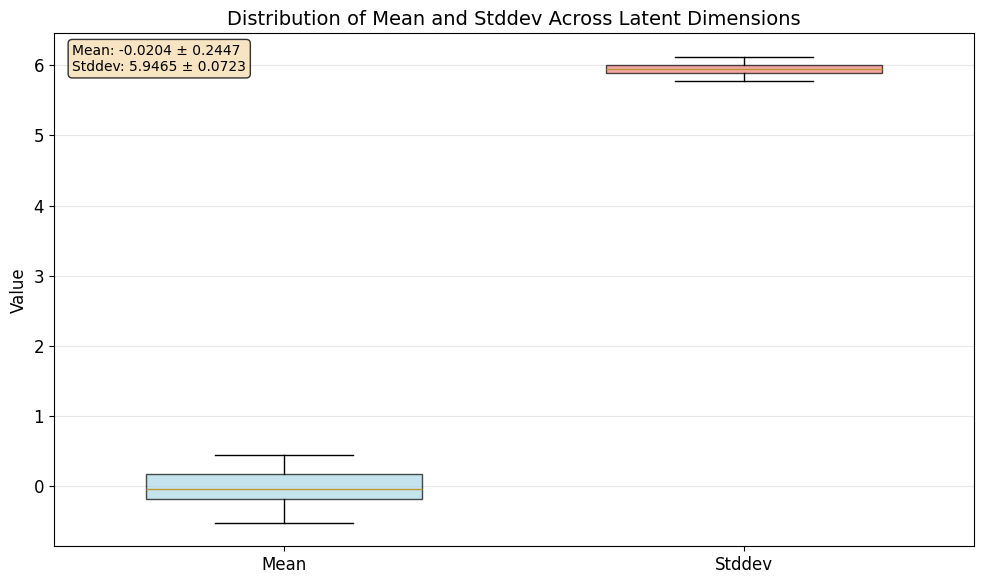

In [96]:
# Encode the entire training set into latent space
print("Encoding training set into latent space...")
vae.eval()

# Create a DataLoader for the entire dataset
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

latent_representations = []

with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(utils.device)
        
        # Encode to latent space using the mean (mu)
        x = batch.view(batch.shape[0], -1).float()
        hidden = vae.encoder(x)
        mu = vae.to_mu(hidden)
        
        latent_representations.append(mu.cpu().numpy())

# Concatenate all batches
latent_representations = np.concatenate(latent_representations, axis=0)
print(f"Encoded {len(latent_representations)} samples into {latent_representations.shape[1]}D latent space")

# Compute mean and stddev for each latent dimension
latent_means = np.mean(latent_representations, axis=0)
latent_stddevs = np.std(latent_representations, axis=0)

print(f"\nMean across dimensions: {np.mean(latent_means):.4f} ± {np.std(latent_means):.4f}")
print(f"Stddev across dimensions: {np.mean(latent_stddevs):.4f} ± {np.std(latent_stddevs):.4f}")

# Create box plot for mean and stddev
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for box plot
box_data = [latent_means, latent_stddevs]
box_labels = ['Mean', 'Stddev']

# Create box plot
bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6)

# Color the boxes
colors = ['lightblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Customize the plot
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Distribution of Mean and Stddev Across Latent Dimensions', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Add statistics text
stats_text = f'Mean: {np.mean(latent_means):.4f} ± {np.std(latent_means):.4f}\n'
stats_text += f'Stddev: {np.mean(latent_stddevs):.4f} ± {np.std(latent_stddevs):.4f}'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        fontsize=10)

plt.tight_layout()
plt.show()
